# Sentence Feature Debug Walkthrough (Adaptive Localization)

This notebook walks through:
1. Loading inputs (examples, sentences, localization)
2. Inspecting a single example and adaptive localization indices
3. Computing adaptive deltas (binary search / refinement probes)
4. Optionally computing attention-based downstream features (Thought Anchors style)
5. Running `extract_sentence_features.py` on a small subset
6. Inspecting outputs and labels

Notes:
- `sentence_localization_batch.py` defaults to `--method adaptive`.
- With adaptive localization, only a subset of sentence indices have deception rates.
- Labels are computed using the *previous localized index* (not the previous sentence).


In [1]:
from pathlib import Path
import sys, os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

BASE = Path("/playpen-ssd/smerrill/deception2/BS/Results/SentencePipeline/v1")
SRC = Path("/playpen-ssd/smerrill/deception2/BS/src")
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

EXAMPLES_PATH = BASE / "examples.jsonl"
SENTENCES_PATH = BASE / "sentences.jsonl"
LOCALIZATION_PATH = BASE / "localization"  # directory from run_sentence_localization_batch_multi_gpu.sh
OUT_DIR = BASE / "debug_features"
OUT_DIR.mkdir(parents=True, exist_ok=True)

ATTN_ENABLED = True
ATTN_MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
ATTN_MAX_TOKENS = 8000
ATTN_MIN_SENTENCE_DISTANCE = 4
EMPTY_MEAN_VALUE = 0.0  # fill for empty past/future
ATTN_LAYER_IDXS = [-1]  # list; -1 = last layer
ATTN_HEAD_IDXS = None  # None = all heads; or list of ints
ATTN_HEAD_AGG = "mean"  # mean | single (uses first head index)
ATTN_HEAD_AGG_METHOD = "weighted_kurtosis"  # mean | max | median | weighted_kurtosis | topk_kurtosis_mean | topk_kurtosis_max
ATTN_HEAD_TOPK = 5
MAX_SENTENCES_FOR_DISPLAY = 40
NUM_EXAMPLES_FOR_ANALYSIS = 1000
EXAMPLE_SAMPLE_SEED = 0
EXAMPLE_SAMPLE_STRATEGY = "first"  # first | random
DELTA_THRESHOLD_CLASS = 0.3
TRAIN_SPLIT = 0.8
DEBUG_ATTENTION = True
DEBUG_MAX_EXAMPLES = 3
SANITIZE_ATTENTION_NAN = True
FILL_NAN_FEATURES = True
FILL_NAN_VALUE = 0.0

LOCALIZATION_MODE = "adaptive"  # adaptive | full | auto
ONLY_LOCALIZED = True


## Motivation (From Thought Anchors)

We treat attention as a *signal* of which earlier sentences influence later reasoning (not a causal guarantee). For each attention head, we convert token-token attention into a sentence-sentence matrix by averaging over all token pairs between sentences. We then measure how much each sentence receives attention from *downstream* sentences (only pairs at least four sentences apart to emphasize long-range links). This yields a per-head distribution across sentences; heads that strongly focus on a few sentences have high kurtosis. We can use this to identify heads that specialize in tracking important sentences, and then aggregate across heads (mean, median, max, or kurtosis-weighted).


In [3]:
from sentence_pipeline import read_jsonl, write_jsonl

examples = [ex for ex in read_jsonl(EXAMPLES_PATH) if ex.get("example_id")]
sentences = [s for s in read_jsonl(SENTENCES_PATH) if s.get("example_id")]

print("examples:", len(examples))
print("sentences:", len(sentences))
examples[0]


examples: 3000
sentences: 128153


{'meta_model_name': 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B',
 'meta_is_reasoning_model': True,
 'meta_temperature': 0.5,
 'meta_top_p': 0.5,
 'meta_max_tokens': 10000,
 'meta_repetition_penalty': 1.2,
 'meta_num_players': 4,
 'meta_cards_per_player': 5,
 'meta_max_games': 1000,
 'meta_max_turns': 1000,
 'meta_target_deceptive': 1000,
 'meta_save_all': True,
 'meta_save_only_deceptive': False,
 'meta_seed': 0,
 'meta_strategy': 'game_flow',
 'meta_timestamp': 1770423190.1481533,
 'run_id': '2026-02-06/gpu_2',
 'run_date': '2026-02-06',
 'gpu': 'gpu_2',
 'source_path': '/playpen-ssd/smerrill/deception2/BS/Results/DeceptionMining/2026-02-06/gpu_2/deception_samples.jsonl',
 'state_id': 6,
 'sample_idx': 0,
 'seed': 0,
 'deceptive': True,
 'game_id': 0,
 'turn_idx': 6,
 'phase': 'PLAY',
 'current_rank': 8,
 'active_player': 'Carol',
 'hand': ['6d', '7d', '8c', '7c', '2s'],
 'pile_size': 0,
 'history_len': 12,
 'prompt': '<｜begin▁of▁sentence｜>You are Player Carol in a bluffing card game. G

In [4]:
from collections import defaultdict

by_example = defaultdict(list)
for s in sentences:
    by_example[s["example_id"]].append(s)
for ex_id, items in by_example.items():
    items.sort(key=lambda x: x.get("sentence_idx", 0))

example_id = examples[0]["example_id"]
example = next(ex for ex in examples if ex["example_id"] == example_id)
print("example_id:", example_id)
print("action_reasoning chars:", len(example.get("action_reasoning", "")))

for s in by_example[example_id][:5]:
    print(s["sentence_idx"], s["sentence_text"][:120])


example_id: 2026-02-06/gpu_2/state_6/sample_0
action_reasoning chars: 3136
0 Okay, so I'm trying to figure out what to do next in this card game.
1 Let me start by understanding the current state of things based on the information given.
2 First, it's my turn—Carol—and I need to decide whether to play some cards or none.
3 According to the rules, when it's my turn, I can play 0 or more cards, even if there aren't many left.
4 But importantly, every card I play has to be claimed with a specific rank—the required claimed rank right now is 8.


In [5]:
from extract_sentence_features import load_localization_history

loc_file = (Path(LOCALIZATION_PATH) / f"sentence_localization_{example_id.replace('/', '_')}.json")
loc = load_localization_history(str(loc_file))
hist = loc.get(example_id, {})
localized_indices = sorted(hist.keys())
print("localized sentences:", len(localized_indices))
print("localized indices:", localized_indices[:20])

rates = {idx: hist[idx].get("deception_rate") for idx in localized_indices}

prev_idx_map = {}
prev_idx = None
for idx in localized_indices:
    prev_idx_map[idx] = prev_idx
    prev_idx = idx

deltas = {}
for idx in localized_indices:
    rate = rates.get(idx)
    prev_idx = prev_idx_map[idx]
    prev_rate = 0.0 if prev_idx is None else rates.get(prev_idx)
    deltas[idx] = (rate - prev_rate) if (rate is not None and prev_rate is not None) else None

[(i, rates.get(i), prev_idx_map[i], deltas.get(i)) for i in localized_indices[:10]]


localized sentences: 15
localized indices: [0, 14, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


[(0, 0.0, None, 0.0),
 (14, 0.0, 0, 0.0),
 (18, 0.040000000000000036, 14, 0.040000000000000036),
 (19, 0.040000000000000036, 18, 0.0),
 (20, 0.09999999999999998, 19, 0.05999999999999994),
 (21, 0.020000000000000018, 20, -0.07999999999999996),
 (22, 0.31999999999999995, 21, 0.29999999999999993),
 (23, 0.33999999999999997, 22, 0.020000000000000018),
 (24, 0.18000000000000005, 23, -0.15999999999999992),
 (25, 0.19999999999999996, 24, 0.019999999999999907)]

In [6]:
import importlib
import extract_sentence_features as _esf
importlib.reload(_esf)
from extract_sentence_features import _compute_downstream_attention_features

if ATTN_ENABLED:
    import torch
    from transformers import AutoModelForCausalLM, AutoTokenizer

    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(ATTN_MODEL_NAME, use_fast=True, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        ATTN_MODEL_NAME,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        low_cpu_mem_usage=True,
        attn_implementation="eager",
        trust_remote_code=True,
    ).to(device)
    model.eval()

    spans = [{"start": s["start"], "end": s["end"]} for s in by_example[example_id]]
    attn_feats, attn_meta = _compute_downstream_attention_features(
        example.get("action_reasoning", ""),
        spans,
        model=model,
        tokenizer=tokenizer,
        device=device,
        max_tokens=ATTN_MAX_TOKENS,
        add_special_tokens=False,
        min_sentence_distance=ATTN_MIN_SENTENCE_DISTANCE,
    )
    print(attn_meta)
    list(attn_feats.items())[:5]
else:
    print("ATTN_ENABLED is False. Set it to True to compute attention features.")


/playpen-ssd/smerrill/conda_envs/deception/lib/python3.11/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

{'attn_truncated': False, 'attn_num_tokens': 679, 'attn_min_sentence_distance': 4, 'attn_head_kurtosis_mean': 20.19656822731854, 'attn_head_kurtosis_std': 6.390945922242298, 'attn_head_kurtosis_min': 1.9268981603938198, 'attn_head_kurtosis_max': 25.038457173487828, 'attn_head_kurtosis_count': 782, 'attn_head_kurtosis_excess_mean': 17.19656822731854, 'attn_head_kurtosis_excess_std': 6.390945922242298, 'attn_head_kurtosis_excess_min': -1.0731018396061802, 'attn_head_kurtosis_excess_max': 22.038457173487828, 'attn_head_kurtosis_last_layer_mean': 14.825604310261387, 'attn_head_kurtosis_last_layer_std': 5.670927910031354, 'attn_head_kurtosis_last_layer_min': 2.515232717354773, 'attn_head_kurtosis_last_layer_max': 23.00854669110779, 'attn_head_kurtosis_last_layer_count': 26, 'attn_head_kurtosis_last_layer_excess_mean': 11.825604310261387, 'attn_head_kurtosis_last_layer_excess_std': 5.670927910031354, 'attn_head_kurtosis_last_layer_excess_min': -0.48476728264522695, 'attn_head_kurtosis_last_l

In [7]:
# Sentence attention matrix for one layer/head
# (mean over all token pairs between sentence i (query) and sentence j (key))

if ATTN_ENABLED:
    import torch
    import pandas as pd
    import extract_sentence_features as _esf

    def sentence_attention_matrix(attn_tensor, token_sent, num_sentences):
        # attn_tensor: [T, T]
        valid_mask = token_sent >= 0
        valid_token_idx = torch.nonzero(valid_mask, as_tuple=True)[0]
        valid_sent_ids = token_sent[valid_mask]
        token_counts = torch.bincount(valid_sent_ids, minlength=num_sentences)
        token_counts_safe = token_counts.clone()
        token_counts_safe[token_counts_safe == 0] = 1

        # mean attention from each token to each sentence (over key tokens)
        A_valid = attn_tensor[:, valid_token_idx]
        V = torch.zeros((attn_tensor.shape[0], num_sentences), device=attn_tensor.device, dtype=torch.float32)
        V.index_add_(1, valid_sent_ids, A_valid)
        V = V / token_counts_safe.to(dtype=torch.float32)

        # aggregate query tokens by sentence to get sentence-sentence matrix
        M = torch.zeros((num_sentences, num_sentences), device=attn_tensor.device, dtype=torch.float32)
        V_valid = V[valid_token_idx]
        M.index_add_(0, valid_sent_ids, V_valid)
        M = M / token_counts_safe.to(dtype=torch.float32).view(-1, 1)
        return M

    # recompute attention for this example (uses same model/tokenizer already loaded above)
    raw_text = example.get("action_reasoning", "")
    enc = tokenizer(
        raw_text,
        add_special_tokens=False,
        return_offsets_mapping=True,
        return_tensors="pt",
    )
    input_ids = enc["input_ids"][0]
    offsets = enc["offset_mapping"][0].tolist()

    if ATTN_MAX_TOKENS and input_ids.shape[0] > ATTN_MAX_TOKENS:
        input_ids = input_ids[:ATTN_MAX_TOKENS]
        offsets = offsets[:ATTN_MAX_TOKENS]

    spans = [{"start": s["start"], "end": s["end"]} for s in by_example[example_id]]
    token_to_sentence = _esf._map_tokens_to_sentences(offsets, spans)
    token_sent = torch.tensor(token_to_sentence, device=device, dtype=torch.long)
    num_sentences = len(spans)

    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0).to(device), output_attentions=True, use_cache=False)
    attn_layers = outputs.attentions

    # pick layer/head (first from lists)
    layer_list = ATTN_LAYER_IDXS or [-1]
    head_list = ATTN_HEAD_IDXS or [0]
    layer_idx = layer_list[0]
    if layer_idx < 0:
        layer_idx = len(attn_layers) + layer_idx
    head_idx = head_list[0]
    attn = attn_layers[layer_idx][0, head_idx].to(dtype=torch.float32)

    M = sentence_attention_matrix(attn, token_sent, num_sentences).cpu()

    # display a truncated matrix for readability
    display_n = min(MAX_SENTENCES_FOR_DISPLAY, num_sentences)
    M_disp = M[:display_n, :display_n]
    df = pd.DataFrame(M_disp.numpy(), index=range(display_n), columns=range(display_n))
    df
else:
    print("ATTN_ENABLED is False. Set it to True to compute attention matrices.")


In [8]:
# Score sentences by how much downstream attention they receive
# (mean over non-zero entries in column j from rows >= j + ATTN_MIN_SENTENCE_DISTANCE)

import numpy as np

if ATTN_ENABLED:
    M = df.values
    n = M.shape[0]
    min_dist = ATTN_MIN_SENTENCE_DISTANCE

    scores = []
    for j in range(n):
        start_row = min(j + min_dist, n)
        if start_row >= n:
            score = EMPTY_MEAN_VALUE
        else:
            col = M[start_row:, j]
            col = col[col != 0]
            score = col.mean() if col.size else EMPTY_MEAN_VALUE
        scores.append(score)

    # Also compute future-minus-past attention to sentence j
    future_minus_past = []
    for j in range(n):
        future = M[j+1:, j]
        past = M[:j, j]
        future = future[future != 0]
        past = past[past != 0]
        fmean = future.mean() if future.size else EMPTY_MEAN_VALUE
        pmean = past.mean() if past.size else EMPTY_MEAN_VALUE
        future_minus_past.append(fmean - pmean)

    # Build a quick table with sentence text
    import pandas as pd

    sent_texts = [s["sentence_text"] for s in by_example[example_id]][:n]
    df_scores = pd.DataFrame({
        "sentence_idx": list(range(n)),
        "score_downstream_mean": scores,
        "score_future_minus_past": future_minus_past,
        "sentence_text": sent_texts,
    })

    df_scores.sort_values("score_downstream_mean", ascending=False).head(10)
else:
    print("ATTN_ENABLED is False. Set it to True to compute scores.")


In [9]:
# Multi-example analysis: relate attention scores to localization deltas
# This builds df_multi with attention-derived features (no sentence text)

import random
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import extract_sentence_features as _esf

if not ATTN_ENABLED:
    print("ATTN_ENABLED is False. Set it to True to compute attention scores.")
else:
    examples_by_id = {ex["example_id"]: ex for ex in examples}

    # Ensure attention model/tokenizer are loaded
    try:
        model
        tokenizer
        device
    except NameError:
        import torch
        from transformers import AutoModelForCausalLM, AutoTokenizer
        device = "cuda" if torch.cuda.is_available() else "cpu"
        tokenizer = AutoTokenizer.from_pretrained(ATTN_MODEL_NAME, use_fast=True, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(
            ATTN_MODEL_NAME,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            low_cpu_mem_usage=True,
            attn_implementation="eager",
            trust_remote_code=True,
        ).to(device)
        model.eval()

    # Choose example ids
    example_ids = list(examples_by_id.keys())
    if EXAMPLE_SAMPLE_STRATEGY == "random":
        random.seed(EXAMPLE_SAMPLE_SEED)
        sample_ids = random.sample(example_ids, min(NUM_EXAMPLES_FOR_ANALYSIS, len(example_ids)))
    else:
        sample_ids = example_ids[:NUM_EXAMPLES_FOR_ANALYSIS]

    def kurtosis(vals):
        vals = np.array(vals, dtype=float)
        vals = vals[np.isfinite(vals)]
        if len(vals) < 2:
            return float("nan")
        mean = vals.mean()
        m2 = np.mean((vals - mean) ** 2)
        if m2 == 0:
            return 0.0
        m4 = np.mean((vals - mean) ** 4)
        return m4 / (m2 ** 2)

    def downstream_mean_vector(M, min_dist):
        n = M.shape[0]
        out = np.full(n, np.nan)
        for j in range(n):
            start = j + min_dist
            if start >= n:
                continue
            col = M[start:, j]
            col = col[col != 0]
            if col.size:
                out[j] = col.mean()
        return out

    # Helper: sentence attention matrix for a single example
    def sentence_attention_matrix(attn_tensor, token_sent, num_sentences):
        valid_mask = token_sent >= 0
        valid_token_idx = torch.nonzero(valid_mask, as_tuple=True)[0]
        valid_sent_ids = token_sent[valid_mask]
        token_counts = torch.bincount(valid_sent_ids, minlength=num_sentences)
        token_counts_safe = token_counts.clone()
        token_counts_safe[token_counts_safe == 0] = 1

        A_valid = attn_tensor[:, valid_token_idx]
        V = torch.zeros((attn_tensor.shape[0], num_sentences), device=attn_tensor.device, dtype=torch.float32)
        V.index_add_(1, valid_sent_ids, A_valid)
        V = V / token_counts_safe.to(dtype=torch.float32)

        M = torch.zeros((num_sentences, num_sentences), device=attn_tensor.device, dtype=torch.float32)
        V_valid = V[valid_token_idx]
        M.index_add_(0, valid_sent_ids, V_valid)
        M = M / token_counts_safe.to(dtype=torch.float32).view(-1, 1)
        return M

    def compute_features_from_matrix(M, min_dist, empty_value):
        n = M.shape[0]
        feats = {
            "score_downstream_mean": np.zeros(n, dtype=float),
            "score_downstream_max": np.zeros(n, dtype=float),
            "score_downstream_mass": np.zeros(n, dtype=float),
            "score_downstream_entropy": np.zeros(n, dtype=float),
            "score_downstream_gini": np.zeros(n, dtype=float),
            "score_downstream_topk_frac": np.zeros(n, dtype=float),
            "score_future_mean": np.zeros(n, dtype=float),
            "score_past_mean": np.zeros(n, dtype=float),
            "score_future_minus_past": np.zeros(n, dtype=float),
            "score_future_frac": np.zeros(n, dtype=float),
            "score_col_mean": np.zeros(n, dtype=float),
            "score_col_entropy": np.zeros(n, dtype=float),
        }

        for j in range(n):
            # Downstream (distant) rows
            start_row = min(j + min_dist, n)
            if start_row >= n:
                downstream = np.array([], dtype=float)
            else:
                downstream = M[start_row:, j]
            downstream = downstream[downstream != 0]

            # Future and past
            future = M[j+1:, j]
            past = M[:j, j]
            future = future[future != 0]
            past = past[past != 0]

            if downstream.size:
                feats["score_downstream_mean"][j] = downstream.mean()
                feats["score_downstream_max"][j] = downstream.max()
                feats["score_downstream_mass"][j] = downstream.sum()
                w = downstream / downstream.sum() if downstream.sum() > 0 else None
                if w is None:
                    feats["score_downstream_entropy"][j] = empty_value
                else:
                    feats["score_downstream_entropy"][j] = float(-np.sum(w * np.log(w + 1e-12)))

                sorted_down = np.sort(downstream)
                cum = np.cumsum(sorted_down)
                if cum[-1] > 0:
                    gini = (len(sorted_down) + 1 - 2 * np.sum(cum) / cum[-1]) / len(sorted_down)
                else:
                    gini = empty_value
                feats["score_downstream_gini"][j] = gini

                k = min(3, len(sorted_down))
                topk = sorted_down[-k:].sum() if k > 0 else 0.0
                feats["score_downstream_topk_frac"][j] = (topk / sorted_down.sum()) if sorted_down.sum() > 0 else empty_value
            else:
                feats["score_downstream_mean"][j] = empty_value
                feats["score_downstream_max"][j] = empty_value
                feats["score_downstream_mass"][j] = 0.0
                feats["score_downstream_entropy"][j] = empty_value
                feats["score_downstream_gini"][j] = empty_value
                feats["score_downstream_topk_frac"][j] = empty_value

            fmean = future.mean() if future.size else empty_value
            pmean = past.mean() if past.size else empty_value
            feats["score_future_mean"][j] = fmean
            feats["score_past_mean"][j] = pmean
            feats["score_future_minus_past"][j] = fmean - pmean

            fsum = future.sum() if future.size else 0.0
            psum = past.sum() if past.size else 0.0
            denom = fsum + psum
            feats["score_future_frac"][j] = (fsum / denom) if denom > 0 else empty_value

            # Column-level mean/entropy (all rows)
            col_all = M[:, j]
            col_all = col_all[col_all != 0]
            feats["score_col_mean"][j] = col_all.mean() if col_all.size else empty_value
            if col_all.size and col_all.sum() > 0:
                wcol = col_all / col_all.sum()
                feats["score_col_entropy"][j] = float(-np.sum(wcol * np.log(wcol + 1e-12)))
            else:
                feats["score_col_entropy"][j] = empty_value

        return feats

    rows_scores = []
    skipped_no_loc = 0

    for ex_id in sample_ids:
        if ex_id not in by_example:
            continue
        example = examples_by_id.get(ex_id)
        sentences = by_example[ex_id]
        if not example or not sentences:
            continue

        loc_file = Path(LOCALIZATION_PATH) / f"sentence_localization_{ex_id.replace('/', '_')}.json"
        if not loc_file.exists():
            skipped_no_loc += 1
            continue
        loc = load_localization_history(str(loc_file))
        hist = loc.get(ex_id, {})
        localized_indices = sorted(hist.keys())
        if not localized_indices:
            skipped_no_loc += 1
            continue

        rates = {idx: hist[idx].get("deception_rate") for idx in localized_indices}
        prev_idx_map = {}
        prev_idx = None
        for idx in localized_indices:
            prev_idx_map[idx] = prev_idx
            prev_idx = idx

        deltas = {}
        for idx in localized_indices:
            rate = rates.get(idx)
            prev_idx = prev_idx_map[idx]
            prev_rate = 0.0 if prev_idx is None else rates.get(prev_idx)
            deltas[idx] = (rate - prev_rate) if (rate is not None and prev_rate is not None) else None

        raw_text = example.get("action_reasoning", "")
        enc = tokenizer(
            raw_text,
            add_special_tokens=False,
            return_offsets_mapping=True,
            return_tensors="pt",
        )
        input_ids = enc["input_ids"][0]
        offsets = enc["offset_mapping"][0].tolist()
        if ATTN_MAX_TOKENS and input_ids.shape[0] > ATTN_MAX_TOKENS:
            input_ids = input_ids[:ATTN_MAX_TOKENS]
            offsets = offsets[:ATTN_MAX_TOKENS]

        spans = [{"start": s["start"], "end": s["end"]} for s in sentences]
        token_to_sentence = _esf._map_tokens_to_sentences(offsets, spans)
        token_sent = torch.tensor(token_to_sentence, device=device, dtype=torch.long)
        num_sentences = len(spans)

        with torch.no_grad():
            outputs = model(input_ids.unsqueeze(0).to(device), output_attentions=True, use_cache=False)
        attn_layers = outputs.attentions
        if not attn_layers:
            continue

        layer_indices = ATTN_LAYER_IDXS
        if layer_indices is None:
            layer_indices = list(range(len(attn_layers)))
        else:
            layer_indices = [li if li >= 0 else (len(attn_layers) + li) for li in layer_indices]
            layer_indices = [li for li in layer_indices if 0 <= li < len(attn_layers)]

        head_indices = ATTN_HEAD_IDXS
        if head_indices is None:
            head_indices = list(range(attn_layers[layer_indices[0]].shape[1]))
        else:
            head_indices = list(head_indices)

        head_feats = []
        head_kurt = []
        nan_total = 0
        inf_total = 0
        min_val = float("nan")
        max_val = float("nan")

        for li in layer_indices:
            layer = attn_layers[li][0]
            for hi in head_indices:
                if hi >= layer.shape[0]:
                    continue
                attn = layer[hi].to(dtype=torch.float32)
                M = sentence_attention_matrix(attn, token_sent, num_sentences)
                M_np = M.detach().cpu().numpy()

                nan_total += int(np.isnan(M_np).sum())
                inf_total += int(np.isinf(M_np).sum())
                finite = M_np[np.isfinite(M_np)]
                if finite.size:
                    min_val = float(np.nanmin([min_val, finite.min()])) if np.isfinite(min_val) else float(finite.min())
                    max_val = float(np.nanmax([max_val, finite.max()])) if np.isfinite(max_val) else float(finite.max())

                if SANITIZE_ATTENTION_NAN:
                    M_np = np.nan_to_num(M_np, nan=0.0, posinf=0.0, neginf=0.0)

                dm = downstream_mean_vector(M_np, ATTN_MIN_SENTENCE_DISTANCE)
                hk = kurtosis(dm)
                head_kurt.append(hk)
                head_feats.append(compute_features_from_matrix(M_np, ATTN_MIN_SENTENCE_DISTANCE, EMPTY_MEAN_VALUE))

                if ATTN_HEAD_AGG == "single":
                    break
            if ATTN_HEAD_AGG == "single":
                break

        if not head_feats:
            continue

        head_kurt = np.array(head_kurt, dtype=float)
        if DEBUG_ATTENTION and len(rows_scores) < DEBUG_MAX_EXAMPLES:
            unmapped = int((np.array(token_to_sentence) < 0).sum())
            print("ATTN debug:", ex_id, "tokens", int(input_ids.shape[0]), "sent", num_sentences,
                  "nan", int(nan_total), "inf", int(inf_total), "min", min_val, "max", max_val,
                  "unmapped_tokens", unmapped)
            print("Head kurtosis (sample):", ex_id, head_kurt[:min(10, len(head_kurt))])

        # Build aggregated features across heads (all methods)
        AGG_METHODS = [
            "mean",
            "max",
            "median",
            "weighted_kurtosis",
            "topk_kurtosis_mean",
            "topk_kurtosis_max",
        ]
        feat_arrays = {}
        feat_keys = head_feats[0].keys()

        weights = np.nan_to_num(head_kurt, nan=0.0)
        weights = np.maximum(weights, 0.0)
        if weights.sum() == 0:
            weights = np.ones_like(weights)
        weights = weights / weights.sum()

        k = min(ATTN_HEAD_TOPK, len(head_kurt))
        topk_idx = np.argsort(np.nan_to_num(head_kurt, nan=-1e9))[-k:]

        for key in feat_keys:
            stack = np.stack([hf[key] for hf in head_feats], axis=0)
            for method in AGG_METHODS:
                if method == "mean":
                    agg = np.nanmean(stack, axis=0)
                elif method == "max":
                    agg = np.nanmax(stack, axis=0)
                elif method == "median":
                    agg = np.nanmedian(stack, axis=0)
                elif method == "weighted_kurtosis":
                    agg = np.average(stack, axis=0, weights=weights)
                elif method == "topk_kurtosis_mean":
                    agg = np.nanmean(stack[topk_idx, :], axis=0)
                elif method == "topk_kurtosis_max":
                    agg = np.nanmax(stack[topk_idx, :], axis=0)
                else:
                    agg = np.nanmean(stack, axis=0)

                feat_arrays[f"{method}::{key}"] = agg

        if DEBUG_ATTENTION:
            feature_nan_counts = {k: int(np.isnan(v).sum()) for k, v in feat_arrays.items()}
            if any(v > 0 for v in feature_nan_counts.values()):
                print("Feature NaNs:", ex_id, feature_nan_counts)

        n_sent = len(sentences)
        sent_positions = [(i / (n_sent - 1)) if n_sent > 1 else 0.0 for i in range(n_sent)]

        for idx in localized_indices:
            rows_scores.append({
                "example_id": ex_id,
                "sentence_idx": idx,
                "sentence_position": sent_positions[idx] if idx < len(sent_positions) else 0.0,
                "delta_deception_rate": deltas.get(idx),
                **{k: v[idx] if idx < len(v) else None for k, v in feat_arrays.items()},
            })

    df_multi = pd.DataFrame(rows_scores)

    # Sanity check: show aggregated feature columns
    agg_cols = [c for c in df_multi.columns if "::score_" in c]
    if not agg_cols:
        print("WARNING: no aggregated feature columns found. Re-run this cell after updates.")
    else:
        print("Sample aggregated columns:", agg_cols[:10])
    print("Examples analyzed:", len(set(df_multi["example_id"])) if not df_multi.empty else 0)
    print("Rows:", len(df_multi))
    print("Skipped (no localization file):", skipped_no_loc)

    # Quick correlations to delta_deception_rate
    df_valid = df_multi.dropna(subset=["delta_deception_rate"])
    if len(df_valid) == 0:
        print("No rows with deltas to analyze.")
    else:
        feat_cols = [c for c in df_valid.columns if ("::score_" in c) or c == "sentence_position"]
        feat_df = df_valid[feat_cols].copy()
        const_cols = [c for c in feat_cols if feat_df[c].nunique(dropna=True) <= 1]
        if const_cols:
            print("Dropping constant features:", const_cols)
            feat_df = feat_df.drop(columns=const_cols)
        corr_series = feat_df.corrwith(df_valid["delta_deception_rate"], method="pearson")
        display(corr_series.sort_values(ascending=False))


ATTN debug: 2026-02-06/gpu_2/state_6/sample_0 tokens 679 sent 31 nan 1953 inf 0 min 0.0 max 1.0 unmapped_tokens 15
Head kurtosis (sample): 2026-02-06/gpu_2/state_6/sample_0 [ 6.18710194 17.98491298 16.68313574 21.53454206 11.99502644 16.03675857
 18.28395434 18.15629176  7.7132818   2.51523291]
Sample aggregated columns: ['mean::score_downstream_mean', 'max::score_downstream_mean', 'median::score_downstream_mean', 'weighted_kurtosis::score_downstream_mean', 'topk_kurtosis_mean::score_downstream_mean', 'topk_kurtosis_max::score_downstream_mean', 'mean::score_downstream_max', 'max::score_downstream_max', 'median::score_downstream_max', 'weighted_kurtosis::score_downstream_max']
Examples analyzed: 1000
Rows: 15352
Skipped (no localization file): 0
Dropping constant features: ['mean::score_past_mean', 'max::score_past_mean', 'median::score_past_mean', 'weighted_kurtosis::score_past_mean', 'topk_kurtosis_mean::score_past_mean', 'topk_kurtosis_max::score_past_mean']


median::score_future_minus_past                0.425262
median::score_future_mean                      0.425262
topk_kurtosis_mean::score_future_mean          0.423038
topk_kurtosis_mean::score_future_minus_past    0.423038
weighted_kurtosis::score_future_minus_past     0.422950
                                                 ...   
mean::score_downstream_gini                   -0.055665
weighted_kurtosis::score_downstream_gini      -0.070654
median::score_downstream_gini                 -0.077091
topk_kurtosis_mean::score_downstream_gini     -0.089518
sentence_position                             -0.106398
Length: 67, dtype: float64

Dropping constant features: ['mean::score_past_mean', 'max::score_past_mean', 'median::score_past_mean', 'weighted_kurtosis::score_past_mean', 'topk_kurtosis_mean::score_past_mean', 'topk_kurtosis_max::score_past_mean']


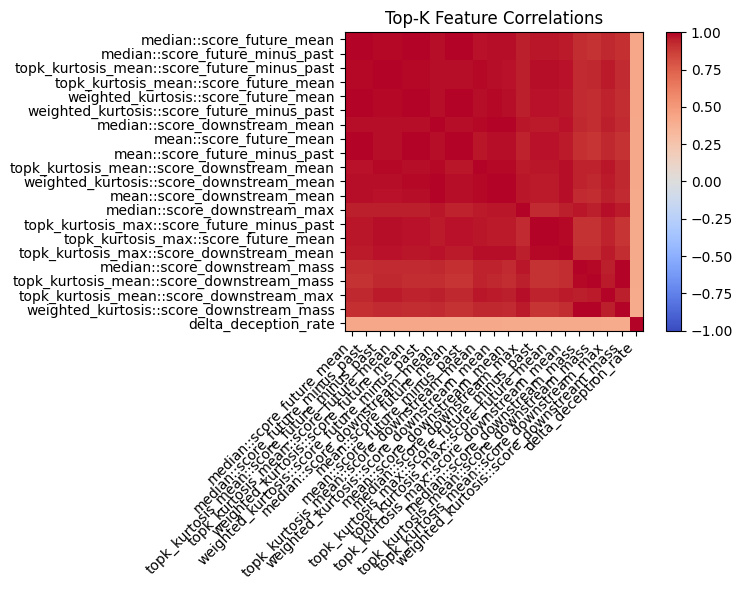

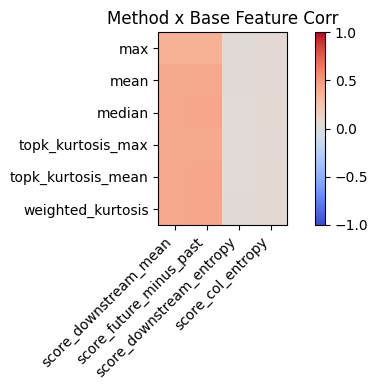

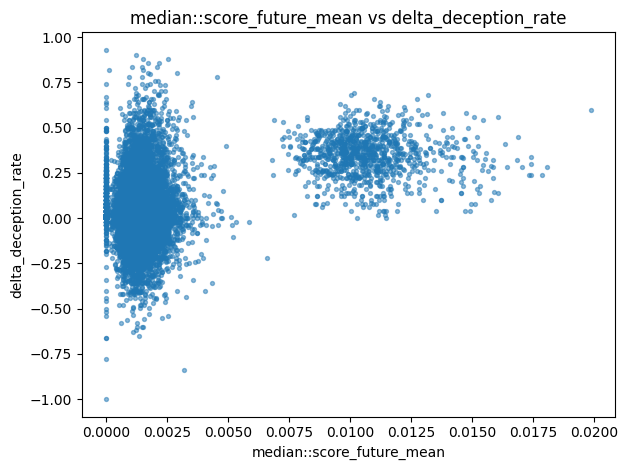

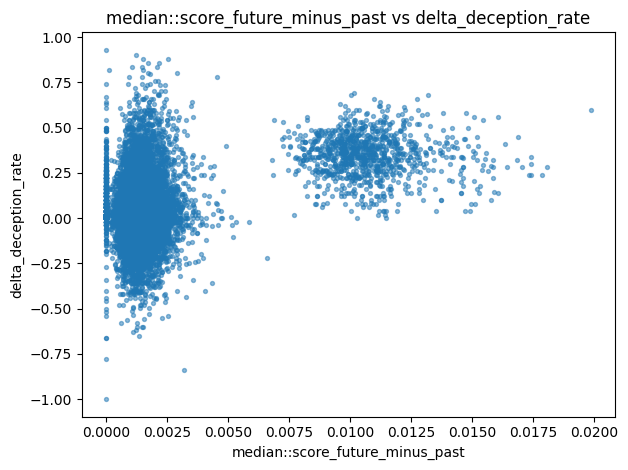

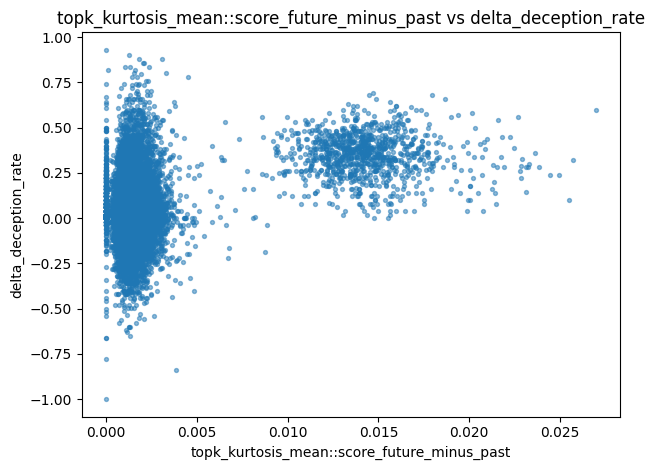

XGBoost reg (test)
MAE: 0.11373687609575686
Pearson corr(pred, delta): 0.4269711185790678
Spearman corr(pred, delta): 0.23591649583525023
XGBoost reg (overfit check, train=test)
MAE: 0.0015680469452803735
Pearson corr: 0.999552903294867
XGBoost clf (delta > 0.3 )
Accuracy: 0.9272491068528743
ROC-AUC: 0.8103655935267483


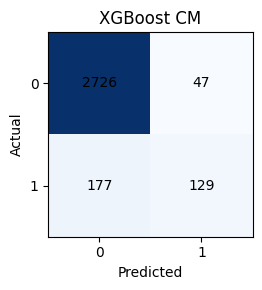

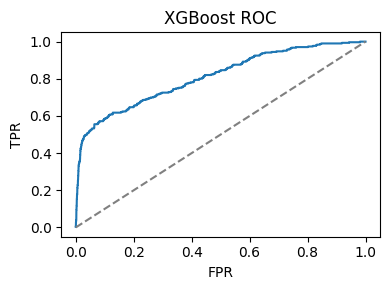

In [10]:
# Feature mining (no text): XGBoost regression + classification + plots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "df_multi" not in globals() or df_multi.empty:
    print("df_multi is empty. Run the multi-example analysis cell first.")
else:
    df = df_multi.copy()

    # Allowed features only (no text, no localization leakage)
    feature_cols = [c for c in df.columns if "::score_" in c] + ["sentence_position"]

    forbidden = {"sentence_text", "deception_rate", "delta_deception_rate", "is_deceptive_sentence"}
    assert not any(col in feature_cols for col in forbidden)

    df = df.replace([np.inf, -np.inf], np.nan)
    if FILL_NAN_FEATURES:
        df[feature_cols] = df[feature_cols].fillna(FILL_NAN_VALUE)
    else:
        df = df.dropna(subset=feature_cols + ["delta_deception_rate"])

    if len(df) == 0:
        print("No rows with scores + deltas to analyze.")
    else:
        # Drop constant features to avoid NaNs
        const_cols = [c for c in feature_cols if df[c].nunique(dropna=True) <= 1]
        if const_cols:
            print("Dropping constant features:", const_cols)
            feature_cols = [c for c in feature_cols if c not in const_cols]

        # Correlation summaries (reduced)
        corr_full = df[feature_cols + ["delta_deception_rate"]].corr()
        corr_to_delta = corr_full["delta_deception_rate"].drop("delta_deception_rate")
        top_k = 20
        top_feats = corr_to_delta.abs().sort_values(ascending=False).head(top_k).index.tolist()

        # Heatmap: top-k features only
        corr_top = df[top_feats + ["delta_deception_rate"]].corr()
        plt.figure(figsize=(8, 6))
        plt.imshow(corr_top, cmap="coolwarm", vmin=-1, vmax=1)
        plt.colorbar()
        plt.xticks(range(len(corr_top.columns)), corr_top.columns, rotation=45, ha="right")
        plt.yticks(range(len(corr_top.index)), corr_top.index)
        plt.title("Top-K Feature Correlations")
        plt.tight_layout()
        plt.show()

        # Heatmap: correlations for a small base-feature set across methods
        base_feats = [
            "score_downstream_mean",
            "score_future_minus_past",
            "score_downstream_entropy",
            "score_col_entropy",
        ]
        methods = sorted({c.split("::")[0] for c in feature_cols if "::" in c})
        corr_table = pd.DataFrame(index=methods, columns=base_feats, dtype=float)
        for m in methods:
            for b in base_feats:
                col = f"{m}::{b}"
                if col in df.columns:
                    corr_table.loc[m, b] = df[col].corr(df["delta_deception_rate"])
        plt.figure(figsize=(6, 4))
        plt.imshow(corr_table, cmap="coolwarm", vmin=-1, vmax=1)
        plt.colorbar()
        plt.xticks(range(len(corr_table.columns)), corr_table.columns, rotation=45, ha="right")
        plt.yticks(range(len(corr_table.index)), corr_table.index)
        plt.title("Method x Base Feature Corr")
        plt.tight_layout()
        plt.show()

        # Scatter plots for top 3 correlated features
        top_feats = top_feats[:3]
        for feat in top_feats:
            plt.figure()
            plt.scatter(df[feat], df["delta_deception_rate"], s=8, alpha=0.5)
            plt.xlabel(feat)
            plt.ylabel("delta_deception_rate")
            plt.title(f"{feat} vs delta_deception_rate")
            plt.tight_layout()
            plt.show()

        # Train/test split by example_id
        example_ids = df["example_id"].unique()
        rng = np.random.default_rng(EXAMPLE_SAMPLE_SEED)
        rng.shuffle(example_ids)
        split = int(len(example_ids) * TRAIN_SPLIT)
        train_ids = set(example_ids[:split])
        test_ids = set(example_ids[split:])

        train = df[df["example_id"].isin(train_ids)]
        test = df[df["example_id"].isin(test_ids)]

        def build_X(d):
            return d[feature_cols].to_numpy(dtype=float)

        def _corr(a, b):
            if len(a) < 2:
                return float("nan")
            return np.corrcoef(a, b)[0, 1]

        # XGBoost regression (delta_deception_rate)
        try:
            import xgboost as xgb
            X_train = build_X(train)
            y_train = train["delta_deception_rate"].to_numpy(dtype=float)
            X_test = build_X(test)
            y_test = test["delta_deception_rate"].to_numpy(dtype=float)

            xgb_reg = xgb.XGBRegressor(
                n_estimators=500,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.9,
                colsample_bytree=0.9,
                objective="reg:squarederror",
                random_state=EXAMPLE_SAMPLE_SEED,
            )
            xgb_reg.fit(X_train, y_train)
            xgb_pred = xgb_reg.predict(X_test)
            print("XGBoost reg (test)")
            print("MAE:", np.mean(np.abs(xgb_pred - y_test)))
            print("Pearson corr(pred, delta):", _corr(xgb_pred, y_test))
            print("Spearman corr(pred, delta):", pd.Series(xgb_pred).corr(pd.Series(y_test), method="spearman"))

            # Overfit check (train=test)
            xgb_reg_over = xgb.XGBRegressor(
                n_estimators=800,
                max_depth=10,
                learning_rate=0.1,
                subsample=1.0,
                colsample_bytree=1.0,
                objective="reg:squarederror",
                random_state=EXAMPLE_SAMPLE_SEED,
            )
            xgb_reg_over.fit(build_X(df), df["delta_deception_rate"].to_numpy(dtype=float))
            over_pred = xgb_reg_over.predict(build_X(df))
            print("XGBoost reg (overfit check, train=test)")
            print("MAE:", np.mean(np.abs(over_pred - df["delta_deception_rate"].to_numpy(dtype=float))))
            print("Pearson corr:", _corr(over_pred, df["delta_deception_rate"].to_numpy(dtype=float)))
        except Exception as e:
            print("xgboost not available for regression:", e)

        def roc_curve(scores, labels):
            order = np.argsort(-scores)
            labels = labels[order]
            tps = np.cumsum(labels == 1)
            fps = np.cumsum(labels == 0)
            tpr = tps / max(tps[-1], 1)
            fpr = fps / max(fps[-1], 1)
            return fpr, tpr

        def plot_confusion_matrix(y_true, y_pred, title):
            tp = int(((y_true == 1) & (y_pred == 1)).sum())
            tn = int(((y_true == 0) & (y_pred == 0)).sum())
            fp = int(((y_true == 0) & (y_pred == 1)).sum())
            fn = int(((y_true == 1) & (y_pred == 0)).sum())
            cm = np.array([[tn, fp], [fn, tp]])
            plt.figure(figsize=(3, 3))
            plt.imshow(cm, cmap="Blues")
            plt.title(title)
            plt.xticks([0, 1], ["0", "1"])
            plt.yticks([0, 1], ["0", "1"])
            for i in range(2):
                for j in range(2):
                    plt.text(j, i, cm[i, j], ha="center", va="center")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.tight_layout()
            plt.show()

        def plot_roc(scores, labels, title):
            fpr, tpr = roc_curve(scores, labels)
            plt.figure(figsize=(4, 3))
            plt.plot(fpr, tpr)
            plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
            plt.title(title)
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.tight_layout()
            plt.show()

        # Classification: delta_deception_rate > DELTA_THRESHOLD_CLASS
        yb_train = (train["delta_deception_rate"].to_numpy(dtype=float) > DELTA_THRESHOLD_CLASS).astype(int)
        yb_test = (test["delta_deception_rate"].to_numpy(dtype=float) > DELTA_THRESHOLD_CLASS).astype(int)

        # ROC-AUC helper
        def roc_auc(scores, labels):
            order = np.argsort(scores)
            ranks = np.empty_like(order)
            ranks[order] = np.arange(len(scores)) + 1
            pos = labels == 1
            n_pos = pos.sum()
            n_neg = len(labels) - n_pos
            if n_pos == 0 or n_neg == 0:
                return float("nan")
            sum_ranks_pos = ranks[pos].sum()
            auc = (sum_ranks_pos - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)
            return auc

        # XGBoost classifier
        try:
            import xgboost as xgb
            Xb_train = build_X(train)
            Xb_test = build_X(test)
            xgb_clf = xgb.XGBClassifier(
                n_estimators=500,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.9,
                colsample_bytree=0.9,
                objective="binary:logistic",
                eval_metric="logloss",
                random_state=EXAMPLE_SAMPLE_SEED,
            )
            xgb_clf.fit(Xb_train, yb_train)
            xgb_probs = xgb_clf.predict_proba(Xb_test)[:, 1]
            xgb_pred = (xgb_probs >= 0.5).astype(int)
            acc_xgb = (xgb_pred == yb_test).mean()
            print("XGBoost clf (delta >", DELTA_THRESHOLD_CLASS, ")")
            print("Accuracy:", acc_xgb)
            print("ROC-AUC:", roc_auc(xgb_probs, yb_test))
            plot_confusion_matrix(yb_test, xgb_pred, "XGBoost CM")
            plot_roc(xgb_probs, yb_test, "XGBoost ROC")
        except Exception as e:
            print("xgboost classifier not available:", e)


weighted_kurtosis::score_future_minus_past      0.301828
median::score_downstream_mean                   0.084534
median::score_future_mean                       0.045773
weighted_kurtosis::score_future_mean            0.028258
weighted_kurtosis::score_downstream_mean        0.022477
sentence_position                               0.016534
topk_kurtosis_mean::score_downstream_mean       0.015464
topk_kurtosis_mean::score_future_minus_past     0.014017
median::score_future_minus_past                 0.013748
max::score_downstream_entropy                   0.010834
max::score_col_mean                             0.010710
topk_kurtosis_mean::score_future_mean           0.010163
mean::score_col_entropy                         0.009730
median::score_downstream_mass                   0.009724
weighted_kurtosis::score_downstream_max         0.009638
topk_kurtosis_mean::score_downstream_mass       0.009626
mean::score_future_mean                         0.009612
topk_kurtosis_max::score_downst

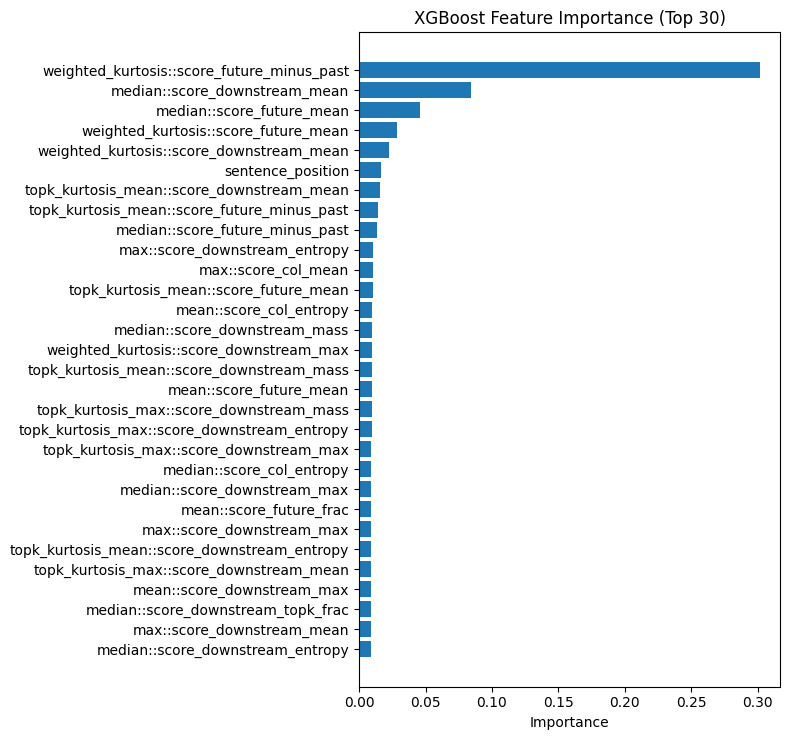

In [11]:
imp = pd.Series(xgb_clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(imp.head(30))
# 2) Booster importances with explicit type
booster = xgb_clf.get_booster()
score_gain = booster.get_score(importance_type="gain")
score_weight = booster.get_score(importance_type="weight")
score_cover = booster.get_score(importance_type="cover")

# Map to full feature list (missing features get 0)
def to_series(score_dict, feature_cols):
    return pd.Series({f: score_dict.get(f, 0.0) for f in feature_cols}).sort_values(ascending=False)

print("GAIN:\n", to_series(score_gain, feature_cols).head(30))
print("WEIGHT:\n", to_series(score_weight, feature_cols).head(30))
print("COVER:\n", to_series(score_cover, feature_cols).head(30))
TOP_K = 30

imp = pd.Series(xgb_clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
imp_top = imp.head(TOP_K)[::-1]

plt.figure(figsize=(8, max(4, 0.25 * TOP_K)))
plt.barh(imp_top.index, imp_top.values)
plt.title(f"XGBoost Feature Importance (Top {TOP_K})")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


